## 03_modeling

**Description:** Creating, fitting, and scoring 3 types of classification models. The highest and best fit model will be moved unto predicting on new, real-world data

In [53]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

**Retrieving values from Previous Notebook**

In [10]:
with open('../pickle/svd_df.pkl', 'rb') as f:
    svd_df = pickle.load(f)
with open('../pickle/target.pkl', 'rb') as f:
    target = pickle.load(f)
with open('../pickle/term_df.pkl', 'rb') as f:
    term_df = pickle.load(f)
with open('../pickle/term_df_2.pkl', 'rb') as f:
    term_df_2 = pickle.load(f)

### Initializing Train-Test-Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(svd_df, target, stratify=target, random_state=42)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(term_df, target, stratify=target, random_state=42)
X_train_full_2, X_test_full_2, y_train_full_2, y_test_full_2 = train_test_split(term_df_2, target, stratify=target, random_state=42)

Given how closely aligned headlines from The Onion and non-Onion news sources are within my dataset, I'm unsure which model will end up providing me with the best predictions. Therefore, I will explore a number of different models:
- K-Nearest Neighbors
- Logistic Regression
- Random Forest

Afterwards, I'll consider boosting the model which achieves the highest accuracy score.

### Using KNN

**Initializing `KNN` through `GridsearchCV`**

In [12]:
knn_grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(5,30,5)})
knn_grid_full = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(5,30,5)})
knn_grid_full_2 = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(5,30,5)})

**Fitting KNN**

**CAUTION: Please note that each of the below model fitting cells are comprised of 3 gridsearches! Run at your own risk**

In [14]:
knn_grid.fit(X_train, y_train)
knn_grid_full.fit(X_train_full, y_train_full)
knn_grid_full_2.fit(X_train_full_2, y_train_full_2)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 5, 10, 15, 20, 25])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [15]:
knn_grid.best_score_, knn_grid_full.best_score_, knn_grid_full_2.best_score_

(0.6335554209569958, 0.6155360387643852, 0.6188673531193216)

In [16]:
knn_grid.best_estimator_, knn_grid_full.best_estimator_, knn_grid_full_2.best_estimator_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=15, p=2,
            weights='uniform'),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=10, p=2,
            weights='uniform'),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=10, p=2,
            weights='uniform'))

The number of estimators that proved to be optimal being slightly different for the SVD model is interesting. Perhaps due to the sheer number of features in the other two models, greater than 10 neighbors caused too much variance within the predictions.

In [17]:
knn_grid.grid_scores_, knn_grid_full.grid_scores_, knn_grid_full_2.grid_scores_

([mean: 0.58767, std: 0.02487, params: {'n_neighbors': 5},
  mean: 0.61750, std: 0.02392, params: {'n_neighbors': 10},
  mean: 0.63356, std: 0.01067, params: {'n_neighbors': 15},
  mean: 0.61205, std: 0.00482, params: {'n_neighbors': 20},
  mean: 0.60736, std: 0.00816, params: {'n_neighbors': 25}],
 [mean: 0.60100, std: 0.01230, params: {'n_neighbors': 5},
  mean: 0.61554, std: 0.00085, params: {'n_neighbors': 10},
  mean: 0.59509, std: 0.00855, params: {'n_neighbors': 15},
  mean: 0.58692, std: 0.01583, params: {'n_neighbors': 20},
  mean: 0.58268, std: 0.01225, params: {'n_neighbors': 25}],
 [mean: 0.60645, std: 0.01476, params: {'n_neighbors': 5},
  mean: 0.61887, std: 0.00398, params: {'n_neighbors': 10},
  mean: 0.59903, std: 0.00533, params: {'n_neighbors': 15},
  mean: 0.59010, std: 0.01869, params: {'n_neighbors': 20},
  mean: 0.58571, std: 0.01702, params: {'n_neighbors': 25}])

**Scoring KNN**

In [18]:
knn_grid.score(X_train, y_train), knn_grid.score(X_test, y_test)

(0.7412174439733494, 0.6403269754768393)

In [19]:
knn_grid_full.score(X_train_full, y_train_full), knn_grid_full.score(X_test_full, y_test_full)

(0.7369775893397941, 0.6307901907356949)

In [21]:
knn_grid_full_2.score(X_train_full_2, y_train_full_2), knn_grid_full_2.score(X_test_full_2, y_test_full_2)

(0.7372804360993337, 0.6330608537693007)

**Analysis:** While the training split score was what I would consider satisfactory, the test split score leaves much to be desired. The near 10% difference in accuracy scores tells me that there's quite a bit of overfitting at play here. I will jump to using Logistic Regression (also through `GridSearchCV`) to see if I can derive a better model.

### Using Logistic Regression

**Initializing `LogisticRegression` through `GridSearchCV`**

In [23]:
log_grid = GridSearchCV(LogisticRegression(), {'penalty': ['l1', 'l2'],'C': np.logspace(.01, 1, 15)})                                                
log_grid_full = GridSearchCV(LogisticRegression(), {'penalty': ['l1', 'l2'],'C': np.logspace(.01, 1, 15)})                                                    
log_grid_full_2 = GridSearchCV(LogisticRegression(), {'penalty': ['l1', 'l2'], 'C': np.logspace(.01, 1, 15)})

**CAUTION: Please note that the below model fitting cell is comprised of 3 gridsearches! Run at your own risk**

In [24]:
log_grid.fit(X_train, y_train), log_grid_full.fit(X_train_full, y_train_full), log_grid_full_2.fit(X_train_full_2, y_train_full_2)

(GridSearchCV(cv=None, error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
        fit_params={}, iid=True, n_jobs=1,
        param_grid={'penalty': ['l1', 'l2'], 'C': array([ 1.02329,  1.20424,  1.41719,  1.6678 ,  1.96271,  2.30978,
         2.71823,  3.1989 ,  3.76456,  4.43025,  5.21366,  6.1356 ,
         7.22057,  8.49739, 10.     ])},
        pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0),
 GridSearchCV(cv=None, error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)

In [25]:
log_grid.best_score_, log_grid_full.best_score_, log_grid_full_2.best_score_

(0.8031496062992126, 0.8107207752877045, 0.815717746820109)

In [26]:
log_grid.best_estimator_, log_grid_full.best_estimator_, log_grid_full_2.best_estimator_

(LogisticRegression(C=1.962714553886212, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 LogisticRegression(C=1.2042434302912746, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 LogisticRegression(C=2.7182269518353372, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False))

In [48]:
log_grid.grid_scores_

[mean: 0.77741, std: 0.00478, params: {'C': 1.023292992280754, 'penalty': 'l1'},
 mean: 0.80133, std: 0.00465, params: {'C': 1.023292992280754, 'penalty': 'l2'},
 mean: 0.78407, std: 0.00434, params: {'C': 1.2042434302912746, 'penalty': 'l1'},
 mean: 0.80254, std: 0.00349, params: {'C': 1.2042434302912746, 'penalty': 'l2'},
 mean: 0.78634, std: 0.00487, params: {'C': 1.417191606254852, 'penalty': 'l1'},
 mean: 0.80300, std: 0.00426, params: {'C': 1.417191606254852, 'penalty': 'l2'},
 mean: 0.78604, std: 0.00771, params: {'C': 1.6677957282718336, 'penalty': 'l1'},
 mean: 0.80285, std: 0.00469, params: {'C': 1.6677957282718336, 'penalty': 'l2'},
 mean: 0.78574, std: 0.00827, params: {'C': 1.962714553886212, 'penalty': 'l1'},
 mean: 0.80315, std: 0.00690, params: {'C': 1.962714553886212, 'penalty': 'l2'},
 mean: 0.78846, std: 0.00730, params: {'C': 2.3097843187477425, 'penalty': 'l1'},
 mean: 0.80285, std: 0.00839, params: {'C': 2.3097843187477425, 'penalty': 'l2'},
 mean: 0.79194, std: 0

**Scoring LogisticRegression**

In [27]:
log_grid.score(X_train, y_train), log_grid_full.score(X_train_full, y_train_full), log_grid_full_2.score(X_train_full_2, y_train_full_2)

(0.8687159297395518, 0.9099030890369473, 0.9364021804966687)

In [28]:
log_grid.score(X_test, y_test), log_grid_full.score(X_test_full, y_test_full), log_grid_full_2.score(X_test_full_2, y_test_full_2)

(0.804268846503179, 0.8083560399636693, 0.8169845594913715)

**Analysis:** The scores are both much better with logistic regrssion, and they're also less overfit. I will consider bringing this one into production. Before making my final decision, however, I'd like to make sure that I've explored utilizing an ensemble method. These methods [generally](https://blog.statsbot.co/ensemble-learning-d1dcd548e936) arrive at a better predictive performance as compared to a single model. I'll start with Random Forest.

### Using Random Forest

**Initializing Random Forest through `GridSearch CV`**

In [31]:
np.sqrt(1000), np.sqrt(3488), np.sqrt(4168)

(31.622776601683793, 59.0592922409336, 64.5600495662759)

In [38]:
rf_grid = GridSearchCV(RandomForestClassifier(min_samples_leaf=3, random_state=42), {'n_estimators': [150, 170, 190],'warm_start': [True, False]})
rf_grid_full = GridSearchCV(RandomForestClassifier(min_samples_leaf=3, random_state=42), {'n_estimators': [110, 130, 150],'warm_start': [True, False]})
rf_grid_full_2 = GridSearchCV(RandomForestClassifier(min_samples_leaf=3, random_state=42), {'n_estimators': [150, 170, 190],'warm_start': [True, False]})

**CAUTION: Please note that the below model fitting cell is comprised of 3 gridsearches! Run at your own risk**

In [39]:
rf_grid.fit(X_train, y_train), rf_grid_full.fit(X_train_full, y_train_full), rf_grid_full_2.fit(X_train_full_2, y_train_full_2);

In [41]:
rf_grid.best_score_, rf_grid_full.best_score_, rf_grid_full_2.best_score_

(0.7690793458509994, 0.7718049666868565, 0.7774076317383404)

In [43]:
rf_grid.best_params_, rf_grid_full.best_params_, rf_grid_full_2.best_params_

({'n_estimators': 150, 'warm_start': True},
 {'n_estimators': 110, 'warm_start': True},
 {'n_estimators': 150, 'warm_start': True})

In the process of developing this ensemble model, I tried tuning the following hyperparameters:
- `n_estimators`
- `max_features`
- `min_samples_leaf`
- `warm_start`

In [44]:
rf_grid.score(X_train, y_train), rf_grid_full.score(X_train_full, y_train_full), rf_grid_full_2.score(X_train_full_2, y_train_full_2)

(0.9959115687462144, 0.8961235614778922, 0.9017262265293762)

In [45]:
rf_grid.score(X_test, y_test), rf_grid_full.score(X_test_full, y_test_full), rf_grid_full_2.score(X_test_full_2, y_test_full_2)

(0.7620345140781108, 0.7806539509536785, 0.790644868301544)

**Analysis**: I'm surprised at just how overfit each model is, especially the model which utilzed SVD. The SVD dataset contains fewer than 1/3rd of the features within the other two datasets, yet going through several gridsearches still landed it with the greatest variance between training and test scores.

I had assumed a greater number of features would lead to a more overfit Random Forest model, yet it turns out that the greatest number of features resulted in the *least* overfit model.

### Boosting My Best Model

Now that I've iterated through a number of different grid searches, I'd like to try boosting my most successful base model to see if there's any additional improvement to be gained.

In [46]:
ad = AdaBoostClassifier(base_estimator=LogisticRegression(C=2.7182269518353372, class_weight=None, dual=False,fit_intercept=True, intercept_scaling=1, 
                                                          max_iter=100,multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,solver='liblinear', 
                                                          tol=0.0001, verbose=0, warm_start=False))

In [47]:
ad.fit(X_train_full_2, y_train_full_2)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=2.7182269518353372, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [48]:
ad.score(X_train_full_2, y_train_full_2)

0.5854027861901878

In [49]:
ad.score(X_test_full_2, y_test_full_2)

0.5749318801089919

**Analysis**

Using adaptive boosting on my best scored model resulted in a much less accurate model than before. I will not use this any further.

### My Best Model

The top model for classifying headlines as either Satirical or Sensational appears to be a Logarithmic regression model. Let's look further at how the model performed with a confusion matrix.

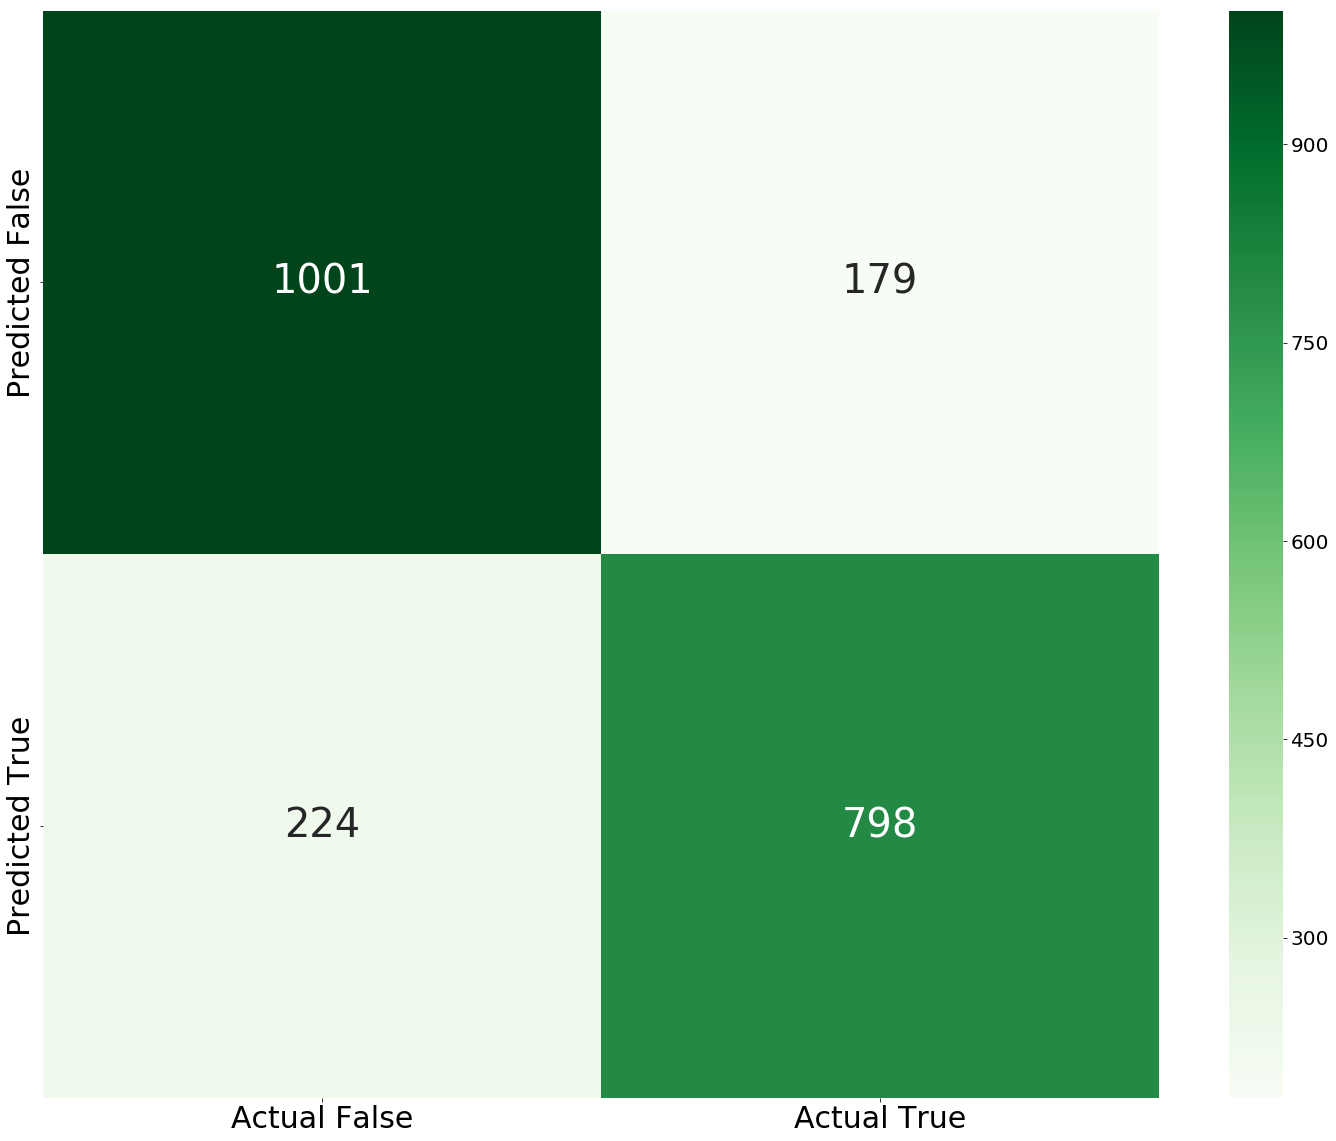

In [92]:
yhat = log_grid_full_2.predict(X_test_full_2)
plt.figure(figsize=(25,20))
ax = sns.heatmap(confusion_matrix(y_test_full_2, yhat), annot=True, annot_kws={'fontsize':40}, fmt="d", cmap="Greens", 
            yticklabels=['Predicted False', 'Predicted True'], xticklabels=['Actual False', 'Actual True'],
            cbar_kws={})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30, va='center');
# plt.savefig('../images/cm.png')

**Analysis**: I think this is great performance for a logarithmic model that didn't feature any SVD, wasn't lemmatized, and incorporated multi-ngrams. Each of the previously mentioned steps is generally seen as a *worthwhile* adjustment to make during preprocessing.

**Select Metrics**:
- An overall accuracy of: $$\frac{1799}{2202}$$
- Sensitivity of: $$\frac{798}{977}$$

Since we're not scoring on anything *actually important*, the most important metric here is accuracy. And, an accuracy of ~81.7% is good enough to move to production (which, in this instance, is just predicting on new headlines).

**Conclusion:** I was a little surprised, thinking that perhaps a model based on a headlines' most similar neighbors would score better. I also beleived that an ensemble model would fare better, considering the generally accepted viewpoint that they're superior to single models. It's possible that I didn't tune the Random Forest models enough, though I did run through a number of different hyperparameters that I assumed would've had significant effects.

Nonetheless, I'll move the logarithmic model through to production, where I'll test it against 10 new posts.

**Pickling model**

In [50]:
with open('../pickle/log_model.pkl', 'wb') as f:
    pickle.dump(log_grid_full_2, f)

**Go To: 04_model_testing**